In [1]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dists

import matplotlib; # matplotlib.use('Agg')  # Allows to create charts with undefined $DISPLAY
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from model import FullyConnected, BayesianRegression
from viz import get_coverage_bounds, plot_1d_posterior_predictive, get_uncertainty_in_gap, plot_basis_functions_1d
from util import *

In [33]:
# define model
w_prior_var = 1.0 # variance of prior over weights
output_var = 0.01 # variance of observation noise
model = BayesianRegression(w_prior_var, output_var)

# parameters of optimizer
LEARNING_RATE = 0.001 
EPOCHS = 6000

# architecture and activation
ACTIVATION = nn.ReLU
num_final_layers = 24
layers = [1, 144, 24, num_final_layers, 1]

# define a neural network feature basis and final layer
basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)


In [3]:
# set training data
N = 20
# x_train = dists.Uniform(-1.0, -0.5).sample((N/2, 1))
x_train = torch.cat((dists.Uniform(-1.0, -0.2).sample((N//2, 1)), dists.Uniform(0.2, 1).sample((N//2, 1))))
y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)


In [45]:

# define MLE loss
def mle_loss():
    y_pred = final_layer(basis(x_train))
    loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))
    
    return loss, (basis, final_layer)
 
# define MAP loss
def map_loss(k):
    y_pred = final_layer(basis(x_train))
    loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1)) + k*(torch.linalg.norm(torch.cat((basis.get_weights(),final_layer.get_weights())), 2))**2
    
    return loss, (basis, final_layer)


### Visualization for training with MAP, k=0.1

In [54]:
# randomly initialize basis and last layer
basis.rand_init(math.sqrt(w_prior_var))
final_layer.rand_init(math.sqrt(w_prior_var))

# optimize loss to learn network
(basis, final_layer), loss = train_objective(
    list(basis.parameters()) + list(final_layer.parameters()),
    loss_fn_name = "map_loss",
    loss_fn = map_loss,
    lr=LEARNING_RATE,
    print_freq=1000,
    epochs = EPOCHS,
    k=0.1
)

Epoch 0: loss = 3770.4133332846695
Epoch 1000: loss = 239.5685803702546
Epoch 2000: loss = 163.16921862205305
Epoch 3000: loss = 120.17970152789505
Epoch 4000: loss = 89.58540401619695
Epoch 5000: loss = 65.75590596981075
Final Loss = 46.66779753321056


In [55]:
# infer posterior over the last layer weights given the basis
posterior, posterior_mean = model.infer_posterior(basis(x_train), y_train)

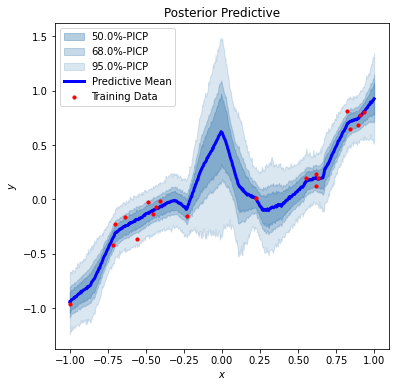

Uncertainty area: 0.5214560634095612


In [56]:
# # sample from posterior predictive
x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)
y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

# visualize posterior predictive
%matplotlib inline
plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred)
print(f"Uncertainty area: {get_uncertainty_in_gap(model, basis, x_train, y_train, 500)}")

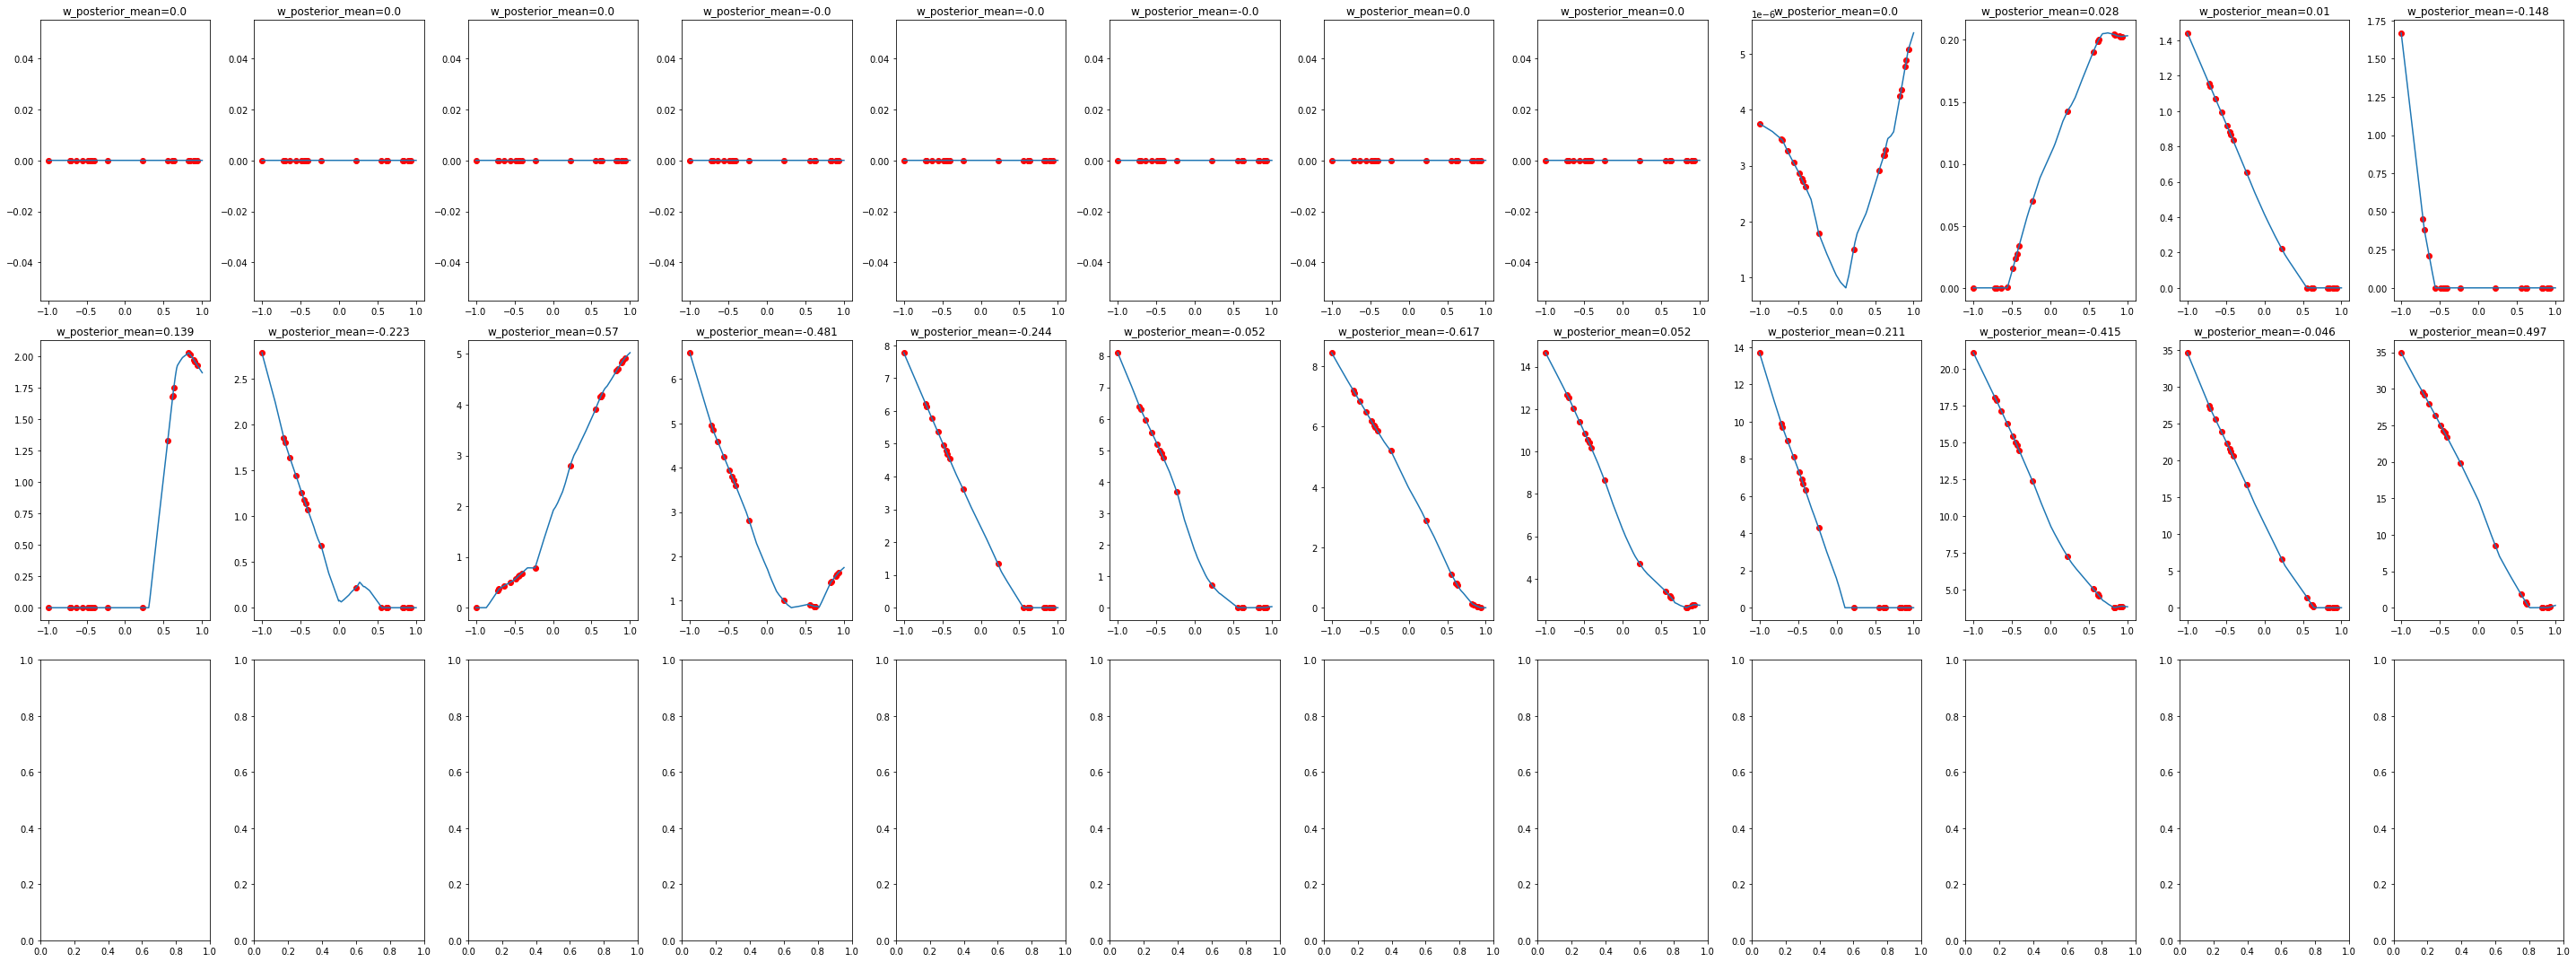

In [57]:
x_vals = np.linspace(-1, 1, 3000)
basis_vals = plot_basis_functions_1d(num_final_layers, x_vals, basis, x_train, posterior_mean, numcols=12)

### Visualization for MLE loss

In [49]:
# randomly initialize basis and last layer
basis.rand_init(math.sqrt(w_prior_var))
final_layer.rand_init(math.sqrt(w_prior_var))

# optimize loss to learn network
(basis, final_layer), loss = train_objective(
    list(basis.parameters()) + list(final_layer.parameters()),
    loss_fn_name = "mle_loss",
    loss_fn = mle_loss,
    lr=LEARNING_RATE,
    print_freq=1000,
    epochs = EPOCHS
)

Epoch 0: loss = 232.79510707287255
Epoch 1000: loss = 0.03178060694604501
Epoch 2000: loss = 0.013363028418848797
Epoch 3000: loss = 0.007547787033270674
Epoch 4000: loss = 0.02513994467735209
Epoch 5000: loss = 0.0015666645880257212
Final Loss = 0.0006977612377057921


In [51]:
# infer posterior over the last layer weights given the basis
posterior, posterior_mean = model.infer_posterior(basis(x_train), y_train)

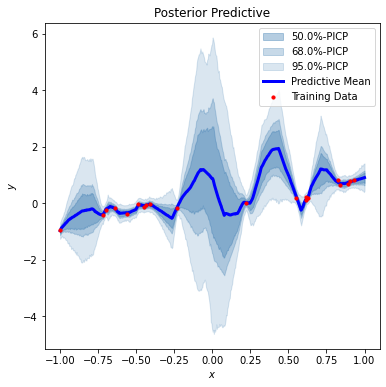

Uncertainty area: 2.69650668177387


In [52]:
# # sample from posterior predictive
x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)
y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

# visualize posterior predictive
%matplotlib inline
plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred)
print(f"Uncertainty area: {get_uncertainty_in_gap(model, basis, x_train, y_train, 500)}")

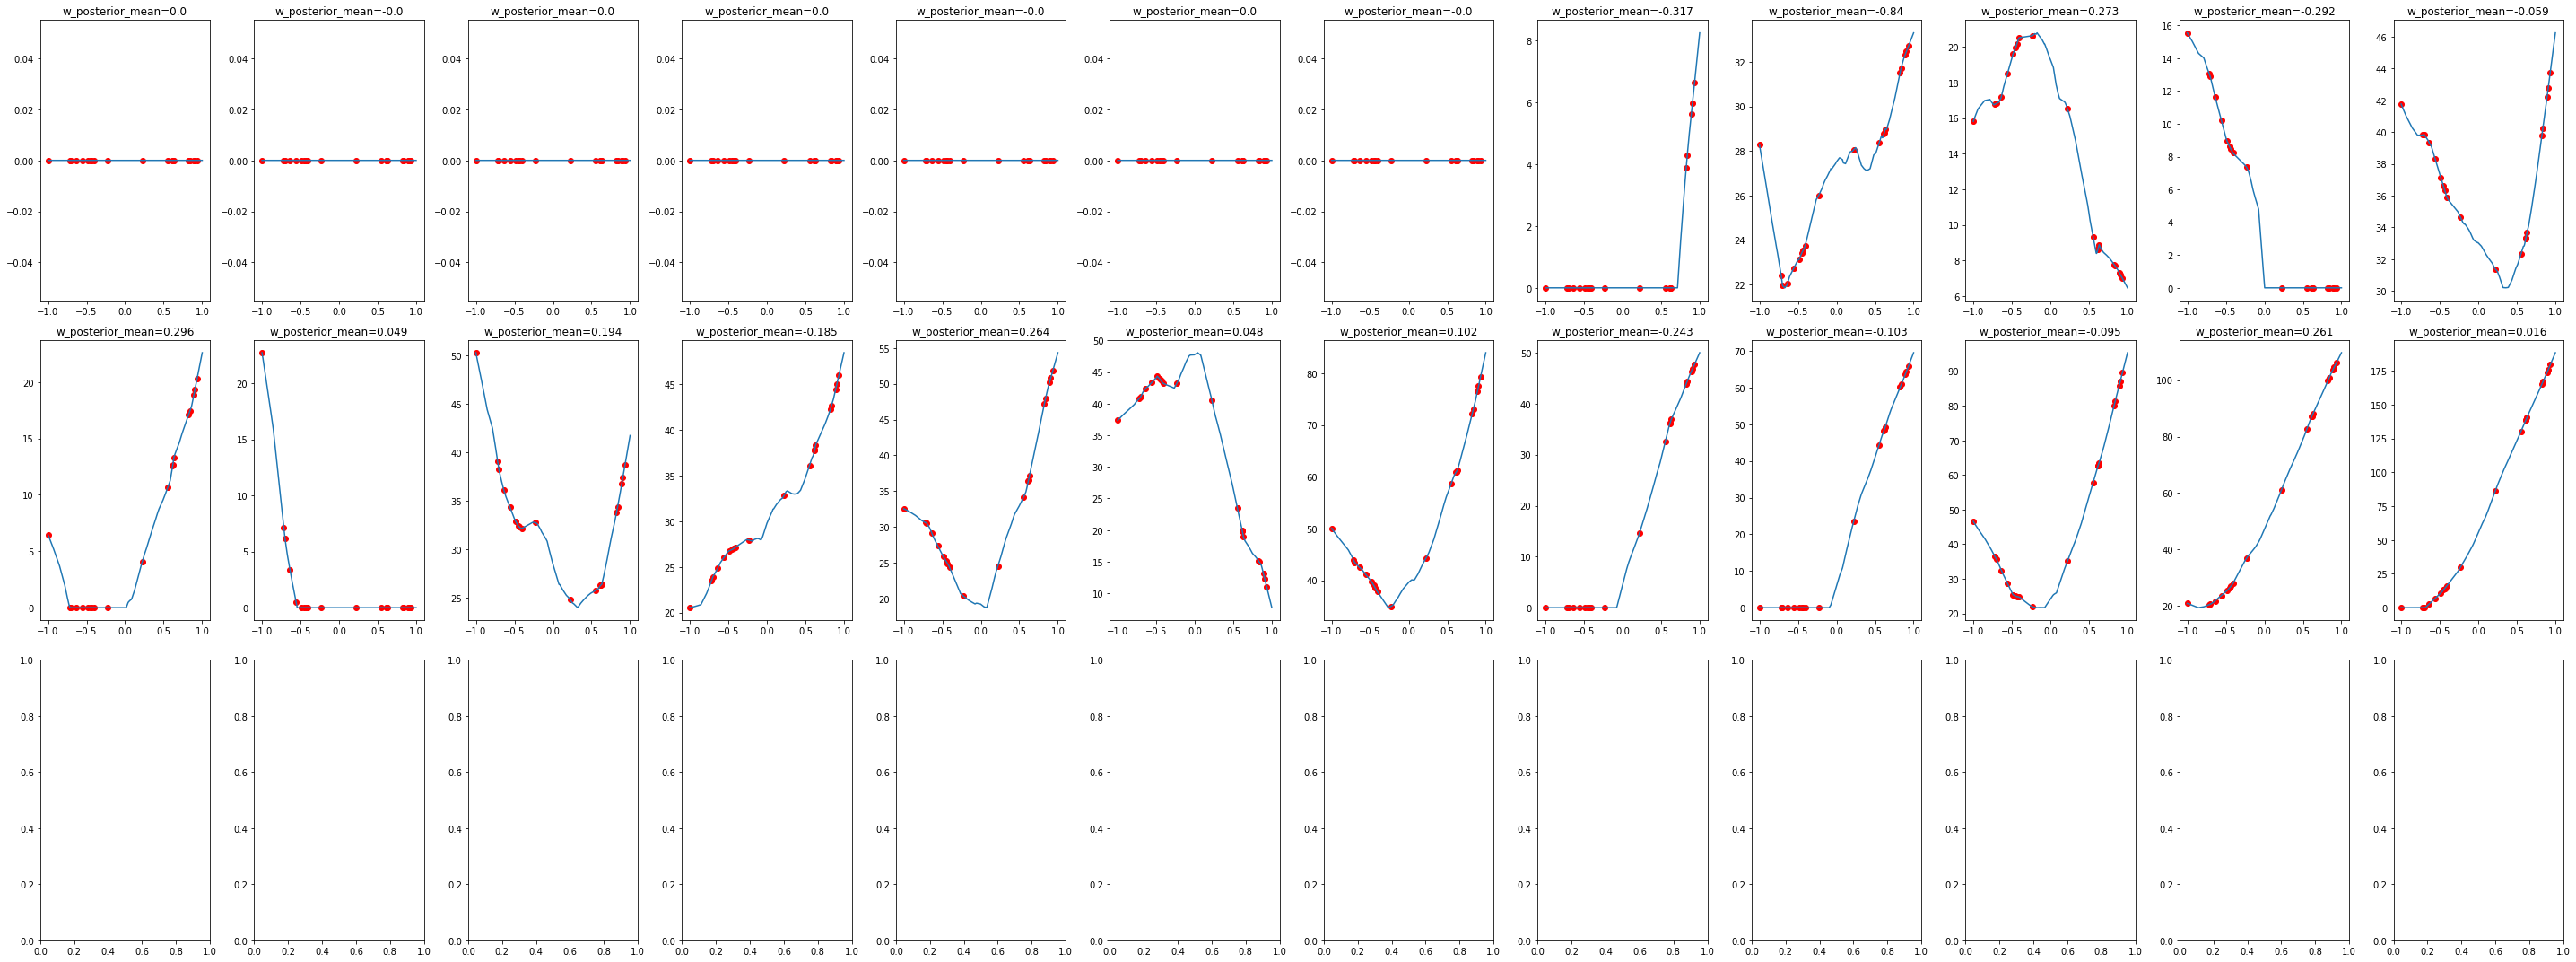

In [53]:
x_vals = np.linspace(-1, 1, 3000)
basis_vals = plot_basis_functions_1d(num_final_layers, x_vals, basis, x_train, posterior_mean, numcols=12)